# State Machine and Object Graph Programming

* (c) Dmitry Ponyatov <<dponyatov@gmail.com>>
* (c) Valeri Rakitine https://www.linkedin.com/in/valrakitine/

#### Install (Linux)

```
~$ git clone -o gh https://github.com/ponyatov/OGP.git
~$ cd OGP
~/OGP$ make install
```
#### Run
```
~/OGP$ make jupyter
```

## Concept Programming

CP here is a programming model described in the works of Enn Heraldovich Tyugu about model-based software development. It is not mean [the term by Alexsandr Stepanov](https://en.wikipedia.org/wiki/Concept_(generic_programming) ) here. The common idea is about making domain models describe the problem in a wide in the form of relation networks, and automatic program (code) synthesis from specifications to solve concrete tasks. This synthesis works over these networks using them as generic knowledge representation.

* http://www.cs.ioc.ee/~tyugu/
* [Концептуальное программирование](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BD%D1%86%D0%B5%D0%BF%D1%82%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)
* Э.Х.Тыугу **Концептуальное программирование** [tyugu]
* J. Symbolic Computation (1988) 5, 359-375\ **The Programming System PRIZ** [sym88]
* М.И.Кахро, А.П.Калья, Э.Х.Тыугу **Инструментальная система программирования ПРИЗ** [priz]

In [1]:
import os
import sys
from graphviz import Digraph

## Base Node Class

The core of the graph interpreter system is a homoiconic model uses a directed graph of objects as both program and data representation. The idea was taken from [1] and extended with the ability to store not only slots (attributes) but also hold any frames in an ordered container.
* https://www.youtube.com/watch?v=nXJ_2uGWM-M

Frames originated as a technology used for knowledge representation in artificial intelligence. They are very close to objects and class hierarchies in object-oriented languages although their fundamental design goals are different. Frames are focused on the explicit and intuitive representation of knowledge whereas objects focus on encapsulation and binding data with processing procedures. Original Marvin Minsky's concept *lacks some principal features for software design*, so it must be extended with the ability to *store sequential collections*.

In practice, the techniques and capabilities of the frame model and object-oriented languages overlap significantly so much as we can treat frames not only a native superset of OOP but they drastically extend object design concepts wider: we can represent any knowledge in frames, and use any programming paradigms as we desire.

In [2]:
class Frame:
    def __init__(self, V):
        # scalar data value
        # mostly names the frame, but also can store things like numbers and strings
        self.val = V
        # named slots = attributes = string-keyed associative array
        self.slot = {}
        # ordered storage = program AST nested elemens = vector = stack
        self.nest = []
        # unique storage id (Redis,RDBMS,..)
        self.sid = '@%x' % id(self)

This data node structure which combines named slots with the ordered collection is definitively required for representing any program source code, as this is very close to classical AST and attribute grammar but uses graph in place of the attributed tree. The object graph (frame) representation of a program as a primary form is effective and *native for any work involved with source code transformations*: synthesis, modifications, analysis, cross-language translation, etc.

Factically, **we don't require any text programming language at all**, as this *Executable Data Structure* can
* hold any program statically (as storage),
* be executed by the EDS-interpreter, so it is *active data*
* translated into any mainstream language or
* [cross-]compiled into machine code.

### Homoiconic programming model

**Homoiconicity** is a property of a programming language in which any program is simultaneously
* an easy to modify *data structure*, and
* an *executable program representation* (program source code).

In a homoiconic language, a programmer does not just have access to the source code, but the language itself specifically provides tools and easy to use methods for convenient work with parts of programs (represented as generic data) in runtime.
* Say, if you include source code of your program in C++ into the distribution package, you can work with the program code as data, but only at the level of text files, or using third-party analysis libraries. In the C++ language itself, there are no dedicated tools for reading, modifying, or generating source code.
* Conversely, in the Lisp language, all programs are represented in the form of executable lists -- these lists are simultaneously a program and the usual universal data structure for working with which the language was specially created.

### EDS Interpreter

In order to use the advantages of homoiconicity in your programs written in any conventional languages (C++, Java,..), you need to integrate an EDS-interpreter into your programs that will
* *execute some data structure as a program*, and additionally
* provides high-level *tools for modifying it* in runtime.

It is not necessary that this interpreter should include a parser of some scripting language, as graph structure can be generated by code in the *implementation* language, and structure self-transformation. To create a program in such a system, you only need to have any way to create an executable data structure in memory: it can be GUI-based drawing, text format parser, external graph database, or some C++ code that forces the compiler to include such a structure in the executable file statically.

### Metaprogramming

Metaprogramming -- when one program modifies (generates) another program, including itself.

Metaprogramming is a method of boosting your efficiency as a programmer by expanding the language you use. If you write very similar code every day, in languages ​​that can do meta (Lisp, Nim), you can write small macro programs that will run during the compilation stage, and generate new code by a template, or modify an existing code the way as you need it. Factically, you can add to the language those features that are needed for a narrow set of your specific tasks.

In order to be able to use metaprogramming in a full scale, the language or programming system you are using must be homoiconic. If you want to use this method with industrial programming languages, the use of an EDS interpreter will allow you to quickly and conveniently solve your problems, paying for it with some losses in the speed of programs and memory usage (see a comparison of interpreters vs the compilers into machine code).

## Dump and plot

To display an object graph in a human-readable form, we need a way to print in a text form and show it in a graphical plot.

### Text tree dump

In [3]:
class Frame(Frame):

    # callback for print
    def __repr__(self): return self.dump(test=False)

    # full tree dump
    def dump(self, done=None, depth=0, prefix='', test=False):
        # subtree header
        tree = self.pad(depth) + self.head(prefix, test)
        # block infinitive recursion on graph cycles
        if not done:
            done = set()  # initialize in the recursion root
        if self in done:
            return tree + ' _/'
        else:
            done.add(self)
        # slot{}s
        for i in self.slot:
            tree += self.slot[i].dump(done, depth+1, '%s = ' % i, test)
        # nest[]ed
        idx = 0
        for j in self.nest:
            tree += j.dump(done, depth+1, '%s = ' % idx, test)
            idx += 1
        # resulting subtree
        return tree

    # short-form dump: <T:V> header only
    def head(self, prefix='', test=False):
        header = '%s<%s:%s>' % (prefix, self._type(), self._val())
        if not test:
            header += ' %s' % self.sid
        return header

    # tree padding
    def pad(self, depth): return '\n' + '\t' * depth

    # type/class tag
    def _type(self): return self.__class__.__name__.lower()

    # .val dump must be tunable for strings, numbers,..
    def _val(self): return '%s' % self.val

In [4]:
# test
hello = Frame('Hello')
print(hello)


<frame:Hello> @7f81f0414898


### Plot /graphviz/

In [5]:
class Frame(Frame):
    # recursive traversal with graphviz calls
    def plot(self, done=None, dot=None, depth=0, parent=None, link='', color='black'):
        def n(frame): return '\"%s\"' % frame.sid
        # block cycles
        if not done:
            done = set()  # initialize in the recursion root
        if self in done:
            return dot
        else:
            done.add(self)
        # init plot
        if not dot:
            dot = Digraph(format='dot', graph_attr={'rankdir': 'LR'})
        # node
        dot.node(n(self), label=self.head(test=True))
        # parent edge
        if parent:
            dot.edge(n(parent), n(self), label=link, color=color)
        # slot{}s
        for i in self.slot:
            self.slot[i].plot(done, dot, depth+1, self,
                              link=i, color='blue')
        # nest[]ed
        idx = 0
        for j in self.nest:
            j.plot(done, dot, depth+1, self,
                   link='/%s' % idx, color='red')
            idx += 1
        # subgraph
        return dot

### Operators

For ease of graph construction, we need to define a set of operators for frames to use in a Python code.

In [6]:
class Frame(Frame):

    # A[key]
    def __getitem__(self, key): return self.slot[key]

    # A[key] = B
    def __setitem__(self, key, that):
        self.slot[key] = that
        return self

    # A << B --> A[B.type] = B
    def __lshift__(self, that):
        return self.__setitem__(that._type(), that)

    # A >> B --> A[B.val] = B
    def __rshift__(self, that):
        return self.__setitem__(that.val, that)

    # A // B
    def __floordiv__(self, that):
        self.nest.append(that)
        return self


<frame:Hello> @7f81f04303c8
	frame = <frame:left> @7f81f0430400
	right = <frame:right> @7f81f04302e8
	0 = <frame:World> @7f81f04304a8


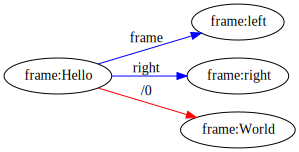

In [7]:
hello = Frame('Hello')
world = hello // Frame('World') << Frame('left') >> Frame('right')
print(world)
world.plot()

## Primitive types

## References

[minsky] Marvin Minsky **Frames for data representation** [html](https://web.media.mit.edu/~minsky/papers/Frames/frames.html)

[tyugu] Э.Х.Тыугу **Концептуальное программирование**. М.: Наука, 1984. 255 с [djvu](https://github.com/ponyatov/OGP/releases/download/260420-5d5e/ConceptProg.ru.djvu)

[sym88] J. Symbolic Computation (1988) 5, 359-375\ **The Programming System PRIZ**<br>\ G.Mints, E.Tyugu, Institute of Cybernetics, Estonian Academy of Sciences,Tallinn 200108, USSR \ [pdf](https://www.academia.edu/18315153/The_programming_system_PRIZ?auto=download)

[priz] **Инструментальная система программирования ЕС ЭВМ (ПРИЗ)** / М.И. Кахро, А.П. Калья, Энн Харальдович Тыугу . – Изд. 2-е – Москва : Финансы и статистика, 1988 . – 181 с ISBN 5-279-00111-2 [pdf](https://github.com/ponyatov/OGP/releases/download/260420-5d5e/PRIZ.ru.pdf)